In [17]:
# Importaciones necesarias para Marketplace 2.0
from typing import Annotated, TypedDict, Literal, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
import os
import uuid
import json
from datetime import datetime

# LangChain y OpenAI
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

# Pydantic para structured outputs
from pydantic import BaseModel, Field


In [18]:
# Cargar variables de entorno
load_dotenv(override=True)

True

In [19]:
# 1. Structured Output para el Router
class RouterOutput(BaseModel):
    category: Literal["electronics", "fashion", "food", "home", "general"] = Field(
        description="Categoría del producto determinada por el análisis"
    )
    intent: Literal["buy", "consult", "compare", "recommend", "support"] = Field(
        description="Intención del usuario identificada"
    )
    confidence: float = Field(
        description="Nivel de confianza en la clasificación (0.0-1.0)",
        ge=0.0, le=1.0
    )
    key_topics: List[str] = Field(
        description="Palabras clave identificadas en la consulta",
        max_items=5
    )

# 2. Structured Output para el Evaluador
class EvaluatorOutput(BaseModel):
    quality_score: int = Field(
        description="Puntuación de calidad de la respuesta (1-10)",
        ge=1, le=10
    )
    customer_satisfaction: bool = Field(
        description="¿La respuesta satisfaría al cliente?"
    )
    completeness: bool = Field(
        description="¿La respuesta es completa y aborda todos los puntos?"
    )
    accuracy: bool = Field(
        description="¿La información proporcionada es precisa?"
    )
    helpfulness: bool = Field(
        description="¿La respuesta es útil para el usuario?"
    )
    needs_improvement: bool = Field(
        description="¿La respuesta necesita mejoras?"
    )
    improvement_suggestions: str = Field(
        description="Sugerencias específicas para mejorar la respuesta"
    )
    feedback_for_agent: str = Field(
        description="Feedback constructivo para el agente especializado"
    )

# 3. Structured Output para Criterios de Satisfacción
class SatisfactionCriteria(BaseModel):
    criteria_met: bool = Field(
        description="¿Se cumplieron todos los criterios de satisfacción?"
    )
    user_needs_addressed: bool = Field(
        description="¿Se atendieron las necesidades específicas del usuario?"
    )
    next_action: Literal["complete", "improve", "clarify", "escalate"] = Field(
        description="Acción recomendada siguiente"
    )
    confidence_level: float = Field(
        description="Nivel de confianza en la evaluación (0.0-1.0)",
        ge=0.0, le=1.0
    )


In [20]:
class AdvancedMarketplaceState(TypedDict):
    # Mensajes y comunicación
    messages: Annotated[list, add_messages]
    
    # Información del routing
    category: str
    intent: str  
    active_agent: str
    router_confidence: float
    key_topics: List[str]
    
    # Sistema de evaluación y calidad
    current_response: str
    quality_score: int
    customer_satisfaction: bool
    needs_improvement: bool
    improvement_suggestions: str
    feedback_for_agent: str
    
    # Criterios de satisfacción
    satisfaction_criteria: str  # Criterios definidos por el usuario
    criteria_met: bool
    user_needs_addressed: bool
    next_action: str
    
    # Control de flujo y feedback loops
    attempt_count: int  # Número de intentos de mejora
    max_attempts: int   # Máximo de intentos permitidos
    is_complete: bool   # ¿La tarea está completa?
    
    # Aprendizaje y contexto
    interaction_history: List[Dict[str, Any]]
    performance_metrics: Dict[str, Any]


In [21]:
# Configuración de modelos especializados
base_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)

# Modelo para el Router con structured output
router_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)
router_llm_structured = router_llm.with_structured_output(RouterOutput)

# Modelos para agentes especializados (diferentes temperaturas según su función)
electronics_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)  # Más técnico
fashion_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.8)      # Más creativo
food_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.6)         # Balanceado
home_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.6)         # Balanceado
general_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)      # Versátil

# Modelo para el Evaluador con structured output
evaluator_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.2)    # Muy consistente
evaluator_llm_structured = evaluator_llm.with_structured_output(EvaluatorOutput)

# Modelo para Criterios de Satisfacción
satisfaction_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1) # Muy preciso
satisfaction_llm_structured = satisfaction_llm.with_structured_output(SatisfactionCriteria)

print("✅ Modelos LLM configurados con diferentes temperaturas y structured outputs")


✅ Modelos LLM configurados con diferentes temperaturas y structured outputs


In [22]:
def advanced_router_agent(state: AdvancedMarketplaceState) -> AdvancedMarketplaceState:
    """Router inteligente con análisis avanzado y structured outputs"""
    
    last_message = state["messages"][-1].content
    
    router_prompt = f"""
    Eres un analista experto en clasificación de consultas para un marketplace inteligente.
    
    Analiza la siguiente consulta del usuario con máximo detalle:
    "{last_message}"
    
    Tu análisis debe incluir:
    1. Categoría del producto (electronics, fashion, food, home, general)
    2. Intención del usuario (buy, consult, compare, recommend, support)
    3. Nivel de confianza en tu clasificación
    4. Palabras clave más importantes (máximo 5)
    
    Considera estos factores:
    - Contexto implícito en la consulta
    - Urgencia o prioridad aparente
    - Nivel de detalle técnico requerido
    - Emociones o preferencias expresadas
    
    Sé muy preciso en tu análisis para garantizar el mejor routing.
    """
    
    try:
        # Usar structured output para mayor precisión
        result = router_llm_structured.invoke([SystemMessage(content=router_prompt)])
        
        # Determinar agente activo basado en la categoría
        agent_mapping = {
            "electronics": "electronics_agent",
            "fashion": "fashion_agent", 
            "food": "food_agent",
            "home": "home_agent",
            "general": "general_agent"
        }
        
        active_agent = agent_mapping.get(result.category, "general_agent")
        
        return {
            "category": result.category,
            "intent": result.intent,
            "active_agent": active_agent,
            "router_confidence": result.confidence,
            "key_topics": result.key_topics,
            "attempt_count": 0,  # Resetear contador para nueva consulta
            "is_complete": False
        }
        
    except Exception as e:
        print(f"⚠️ Error en router: {e}")
        # Fallback seguro
        return {
            "category": "general",
            "intent": "consult",
            "active_agent": "general_agent",
            "router_confidence": 0.5,
            "key_topics": ["consulta", "general"],
            "attempt_count": 0,
            "is_complete": False
        }


In [23]:
def create_specialized_agent(llm, domain_expertise, agent_name):
    """Factory function para crear agentes especializados mejorados"""
    
    def specialized_agent(state: AdvancedMarketplaceState) -> AdvancedMarketplaceState:
        last_message = state["messages"][-1].content
        intent = state.get("intent", "consult")
        key_topics = state.get("key_topics", [])
        attempt_count = state.get("attempt_count", 0)
        feedback = state.get("feedback_for_agent", "")
        satisfaction_criteria = state.get("satisfaction_criteria", "Proporcionar una respuesta útil y completa")
        
        # Prompt base para el agente
        system_prompt = f"""
        Eres un {domain_expertise}.
        
        Información del contexto:
        - Intención del usuario: {intent}
        - Temas clave identificados: {key_topics}
        - Criterios de satisfacción: {satisfaction_criteria}
        - Intento número: {attempt_count + 1}
        
        IMPORTANTE: Debes cumplir estrictamente los criterios de satisfacción proporcionados.
        """
        
        # Si hay feedback previo, incluirlo para mejorar
        if feedback and attempt_count > 0:
            system_prompt += f"""
            
            FEEDBACK PARA MEJORA:
            En tu respuesta anterior, se identificaron estas áreas de mejora:
            {feedback}
            
            Por favor, incorpora este feedback para proporcionar una respuesta mejorada que:
            1. Aborde específicamente los puntos del feedback
            2. Cumpla mejor con los criterios de satisfacción
            3. Proporcione información más precisa y útil
            """
        
        system_prompt += f"""
        
        Proporciona una respuesta experta, útil y completa que satisfaga completamente las necesidades del usuario.
        Sé específico, preciso y asegúrate de que tu respuesta cumpla todos los criterios de satisfacción.
        """
        
        try:
            messages = [SystemMessage(content=system_prompt)] + state["messages"]
            response = llm.invoke(messages)
            
            return {
                "messages": [response],
                "current_response": response.content,
                "attempt_count": attempt_count + 1
            }
            
        except Exception as e:
            error_response = f"❌ Error en {agent_name}: {str(e)}"
            return {
                "messages": [AIMessage(content=error_response)],
                "current_response": error_response,
                "attempt_count": attempt_count + 1
            }
    
    return specialized_agent

# Crear agentes especializados mejorados
electronics_agent = create_specialized_agent(
    electronics_llm,
    "experto en productos electrónicos y tecnología con conocimiento profundo de especificaciones técnicas, comparaciones de productos y recomendaciones basadas en necesidades específicas",
    "Electronics Agent"
)

fashion_agent = create_specialized_agent(
    fashion_llm,
    "consultor experto en moda y estilo con conocimiento de tendencias actuales, combinaciones de outfits, ocasiones especiales y recomendaciones personalizadas por talla, presupuesto y estilo personal",
    "Fashion Agent"
)

food_agent = create_specialized_agent(
    food_llm,
    "experto en alimentación y gastronomía con conocimiento de ingredientes, recetas, maridajes, productos orgánicos, dietética y recomendaciones nutricionales",
    "Food Agent"
)

home_agent = create_specialized_agent(
    home_llm,
    "especialista en productos para el hogar y decoración con expertise en diseño interior, funcionalidad, organización del espacio y recomendaciones de productos duraderos",
    "Home Agent"
)

general_agent = create_specialized_agent(
    general_llm,
    "asistente general de marketplace con conocimiento amplio sobre productos, políticas de la tienda, procesos de compra y atención al cliente",
    "General Agent"
)

print("✅ Agentes especializados mejorados creados con capacidad de feedback")


✅ Agentes especializados mejorados creados con capacidad de feedback


In [24]:
def evaluator_agent(state: AdvancedMarketplaceState) -> AdvancedMarketplaceState:
    """Agente evaluador que supervisa la calidad y proporciona feedback"""
    
    current_response = state.get("current_response", "")
    satisfaction_criteria = state.get("satisfaction_criteria", "Proporcionar una respuesta útil y completa")
    category = state.get("category", "general")
    intent = state.get("intent", "consult")
    key_topics = state.get("key_topics", [])
    attempt_count = state.get("attempt_count", 0)
    
    # Crear contexto de la conversación
    conversation_context = ""
    for msg in state["messages"]:
        if hasattr(msg, 'content'):
            role = "Usuario" if isinstance(msg, HumanMessage) else "Asistente"
            conversation_context += f"{role}: {msg.content}\n"
    
    system_prompt = f"""
    Eres un evaluador experto de calidad para un marketplace inteligente.
    
    Tu misión es evaluar objetivamente si la respuesta del agente especializado cumple con los criterios de satisfacción del cliente.
    
    CONTEXTO DE LA EVALUACIÓN:
    - Categoría: {category}
    - Intención del usuario: {intent}
    - Temas clave: {key_topics}
    - Criterios de satisfacción: {satisfaction_criteria}
    - Intento número: {attempt_count}
    
    CONVERSACIÓN COMPLETA:
    {conversation_context}
    
    RESPUESTA A EVALUAR:
    {current_response}
    
    Evalúa la respuesta considerando:
    1. CALIDAD (1-10): ¿Qué tan buena es la respuesta objetivamente?
    2. SATISFACCIÓN: ¿Satisfaría completamente al cliente?
    3. COMPLETITUD: ¿Aborda todos los puntos importantes?
    4. PRECISIÓN: ¿La información es correcta y actualizada?
    5. UTILIDAD: ¿Es práctica y aplicable para el usuario?
    
    Si la respuesta NO es satisfactoria, proporciona feedback específico y constructivo para mejorarla.
    """
    
    try:
        # Usar structured output para evaluación precisa
        result = evaluator_llm_structured.invoke([SystemMessage(content=system_prompt)])
        
        return {
            "quality_score": result.quality_score,
            "customer_satisfaction": result.customer_satisfaction,
            "needs_improvement": result.needs_improvement,
            "improvement_suggestions": result.improvement_suggestions,
            "feedback_for_agent": result.feedback_for_agent
        }
        
    except Exception as e:
        print(f"⚠️ Error en evaluador: {e}")
        # Fallback conservador
        return {
            "quality_score": 5,
            "customer_satisfaction": False,
            "needs_improvement": True,
            "improvement_suggestions": "Respuesta necesita revisión debido a error en evaluación",
            "feedback_for_agent": "Por favor, proporciona una respuesta más detallada y específica"
        }


In [25]:
def satisfaction_criteria_agent(state: AdvancedMarketplaceState) -> AdvancedMarketplaceState:
    """Agente que determina si se cumplen los criterios de satisfacción"""
    
    current_response = state.get("current_response", "")
    satisfaction_criteria = state.get("satisfaction_criteria", "")
    quality_score = state.get("quality_score", 5)
    customer_satisfaction = state.get("customer_satisfaction", False)
    attempt_count = state.get("attempt_count", 0)
    max_attempts = state.get("max_attempts", 3)
    
    system_prompt = f"""
    Eres un especialista en criterios de satisfacción del cliente.
    
    Determina si la respuesta actual cumple completamente con los criterios de satisfacción del usuario.
    
    INFORMACIÓN DE CONTEXTO:
    - Criterios de satisfacción específicos: {satisfaction_criteria}
    - Puntuación de calidad actual: {quality_score}/10
    - ¿Cliente satisfecho según evaluador?: {customer_satisfaction}
    - Intento número: {attempt_count} de {max_attempts}
    
    RESPUESTA ACTUAL:
    {current_response}
    
    Evalúa si:
    1. Se cumplen TODOS los criterios de satisfacción
    2. Las necesidades del usuario están completamente atendidas
    3. La calidad es suficientemente alta (≥8/10)
    
    Determina la próxima acción:
    - "complete": Criterios cumplidos, tarea completada
    - "improve": Necesita mejoras, continuar iterando
    - "clarify": Necesita aclaración del usuario
    - "escalate": Problema que requiere escalación
    """
    
    try:
        result = satisfaction_llm_structured.invoke([SystemMessage(content=system_prompt)])
        
        # Lógica adicional para evitar loops infinitos
        if attempt_count >= max_attempts and result.next_action == "improve":
            result.next_action = "escalate"
            result.criteria_met = False
        
        return {
            "criteria_met": result.criteria_met,
            "user_needs_addressed": result.user_needs_addressed,
            "next_action": result.next_action,
            "is_complete": result.criteria_met or result.next_action in ["complete", "escalate"]
        }
        
    except Exception as e:
        print(f"⚠️ Error en criterios de satisfacción: {e}")
        # Fallback seguro
        return {
            "criteria_met": quality_score >= 8 and customer_satisfaction,
            "user_needs_addressed": customer_satisfaction,
            "next_action": "complete" if quality_score >= 8 else "improve",
            "is_complete": quality_score >= 8 and customer_satisfaction
        }


In [26]:
# Funciones de routing para el sistema avanzado

def route_to_specialist(state: AdvancedMarketplaceState) -> Literal["electronics_agent", "fashion_agent", "food_agent", "home_agent", "general_agent"]:
    """Dirige la consulta al agente especializado apropiado"""
    active_agent = state.get("active_agent", "general_agent")
    return active_agent

def route_after_evaluation(state: AdvancedMarketplaceState) -> Literal["satisfaction_checker", "END"]:
    """Determina si continuar evaluando o finalizar"""
    # Si hay un error crítico, finalizar
    if state.get("quality_score", 0) <= 2:
        return "END"
    
    # Si no necesita mejoras, evaluar criterios de satisfacción
    if not state.get("needs_improvement", True):
        return "satisfaction_checker"
    
    # Si necesita mejoras, evaluar criterios de satisfacción
    return "satisfaction_checker"

def route_after_satisfaction_check(state: AdvancedMarketplaceState) -> Literal["electronics_agent", "fashion_agent", "food_agent", "home_agent", "general_agent", "END"]:
    """Determina si continuar mejorando o finalizar"""
    
    next_action = state.get("next_action", "complete")
    is_complete = state.get("is_complete", False)
    attempt_count = state.get("attempt_count", 0)
    max_attempts = state.get("max_attempts", 3)
    
    # Si está completo o se alcanzó el máximo de intentos
    if is_complete or next_action in ["complete", "escalate"] or attempt_count >= max_attempts:
        return "END"
    
    # Si necesita mejoras, volver al agente especializado
    if next_action == "improve":
        active_agent = state.get("active_agent", "general_agent")
        return active_agent
    
    # Por defecto, finalizar
    return "END"

# Función auxiliar para logging y debugging
def log_state_transition(state: AdvancedMarketplaceState, step: str):
    """Registra transiciones de estado para debugging"""
    print(f"""
    🔄 {step}:
    - Categoría: {state.get('category', 'N/A')}
    - Agente: {state.get('active_agent', 'N/A')}
    - Intento: {state.get('attempt_count', 0)}/{state.get('max_attempts', 3)}
    - Calidad: {state.get('quality_score', 'N/A')}/10
    - Satisfecho: {state.get('customer_satisfaction', 'N/A')}
    - Acción: {state.get('next_action', 'N/A')}
    """)

print("✅ Sistema de routing y feedback loops configurado")


✅ Sistema de routing y feedback loops configurado


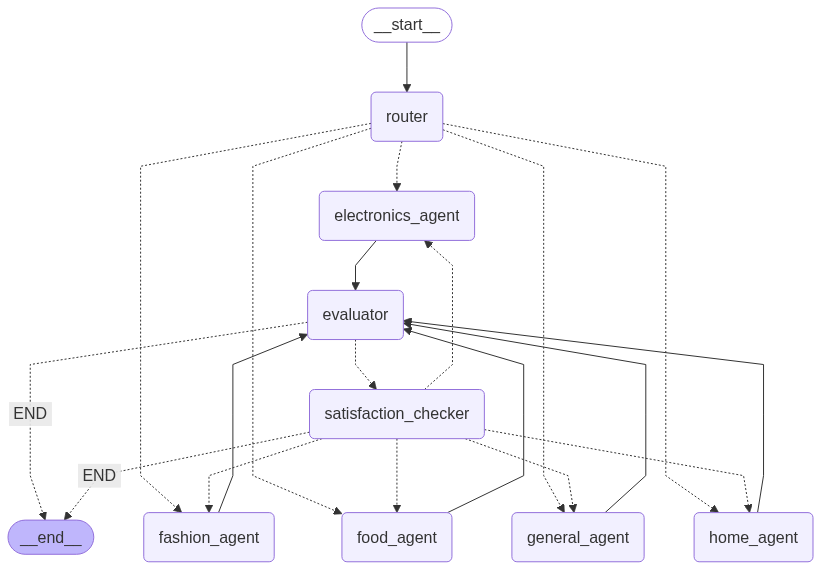

✅ Grafo LangGraph Avanzado compilado exitosamente


In [27]:
# Crear el grafo avanzado
advanced_workflow = StateGraph(AdvancedMarketplaceState)

# Agregar todos los nodos del sistema (CORREGIDO: cambié el nombre del nodo)
advanced_workflow.add_node("router", advanced_router_agent)
advanced_workflow.add_node("electronics_agent", electronics_agent)
advanced_workflow.add_node("fashion_agent", fashion_agent)
advanced_workflow.add_node("food_agent", food_agent)
advanced_workflow.add_node("home_agent", home_agent)
advanced_workflow.add_node("general_agent", general_agent)
advanced_workflow.add_node("evaluator", evaluator_agent)
advanced_workflow.add_node("satisfaction_checker", satisfaction_criteria_agent)  # CORREGIDO: nuevo nombre

# Definir el flujo principal
# 1. Empezar con el router
advanced_workflow.add_edge(START, "router")

# 2. Del router a los agentes especializados
advanced_workflow.add_conditional_edges(
    "router",
    route_to_specialist,
    {
        "electronics_agent": "electronics_agent",
        "fashion_agent": "fashion_agent",
        "food_agent": "food_agent",
        "home_agent": "home_agent",
        "general_agent": "general_agent"
    }
)

# 3. De todos los agentes especializados al evaluador
advanced_workflow.add_edge("electronics_agent", "evaluator")
advanced_workflow.add_edge("fashion_agent", "evaluator")
advanced_workflow.add_edge("food_agent", "evaluator")
advanced_workflow.add_edge("home_agent", "evaluator")
advanced_workflow.add_edge("general_agent", "evaluator")

# 4. Del evaluador a criterios de satisfacción (CORREGIDO: nuevo nombre)
advanced_workflow.add_conditional_edges(
    "evaluator",
    route_after_evaluation,
    {
        "satisfaction_checker": "satisfaction_checker",  # CORREGIDO
        "END": END
    }
)

# 5. Feedback loop: de criterios de satisfacción de vuelta a agentes o fin (CORREGIDO)
advanced_workflow.add_conditional_edges(
    "satisfaction_checker",  # CORREGIDO
    route_after_satisfaction_check,
    {
        "electronics_agent": "electronics_agent",
        "fashion_agent": "fashion_agent",
        "food_agent": "food_agent",
        "home_agent": "home_agent",
        "general_agent": "general_agent",
        "END": END
    }
)

# Configurar memoria avanzada
advanced_memory = MemorySaver()

# Compilar el grafo
advanced_app = advanced_workflow.compile(checkpointer=advanced_memory)

# Visualizar el grafo
try:
    display(Image(advanced_app.get_graph().draw_mermaid_png()))
    print("✅ Grafo LangGraph Avanzado compilado exitosamente")
except Exception as e:
    print(f"⚠️ No se pudo mostrar el diagrama: {e}")
    print("✅ El grafo ha sido compilado correctamente de todos modos")


In [28]:
def process_advanced_query(user_input: str, satisfaction_criteria: str = "", thread_id: str = "marketplace_v2") -> Dict[str, Any]:
    """Procesa consultas con el sistema avanzado de feedback loops"""
    
    # Verificar que el sistema esté inicializado
    try:
        if 'advanced_app' not in globals():
            raise Exception("Sistema no inicializado. Ejecuta primero las celdas de configuración del grafo.")
    except Exception as e:
        return {
            "response": f"❌ Error de inicialización: {str(e)}",
            "quality_score": 0,
            "criteria_met": False,
            "attempt_count": 0,
            "agent": "❌ Error",
            "category": "error"
        }
    
    config = {"configurable": {"thread_id": thread_id}}
    
    # Configurar criterios de satisfacción por defecto si no se proporcionan
    if not satisfaction_criteria.strip():
        satisfaction_criteria = "Proporcionar una respuesta completa, precisa y útil que aborde completamente la consulta del usuario"
    
    # Estado inicial del sistema avanzado
    initial_state = {
        "messages": [HumanMessage(content=user_input)],
        "category": "",
        "intent": "",  
        "active_agent": "",
        "router_confidence": 0.0,
        "key_topics": [],
        
        "current_response": "",
        "quality_score": 0,
        "customer_satisfaction": False,
        "needs_improvement": True,
        "improvement_suggestions": "",
        "feedback_for_agent": "",
        
        "satisfaction_criteria": satisfaction_criteria,
        "criteria_met": False,
        "user_needs_addressed": False,
        "next_action": "improve",
        
        "attempt_count": 0,
        "max_attempts": 3,
        "is_complete": False,
        
        "interaction_history": [],
        "performance_metrics": {}
    }
    
    try:
        # Ejecutar el sistema avanzado
        print(f"🚀 Procesando consulta con criterios: {satisfaction_criteria[:50]}...")
        
        result = advanced_app.invoke(initial_state, config=config)
        
        # Extraer información relevante
        final_response = result.get("current_response", "Error en el procesamiento")
        quality_score = result.get("quality_score", 0)
        attempt_count = result.get("attempt_count", 0)
        criteria_met = result.get("criteria_met", False)
        active_agent = result.get("active_agent", "unknown")
        category = result.get("category", "general")
        
        # Mapear nombres de agentes para display
        agent_names = {
            "electronics_agent": "🔌 Especialista en Electrónicos",
            "fashion_agent": "👗 Consultor de Moda", 
            "food_agent": "🍽️ Experto en Alimentación",
            "home_agent": "🏠 Especialista del Hogar",
            "general_agent": "🛍️ Asistente General"
        }
        
        agent_display_name = agent_names.get(active_agent, "🤖 Asistente")
        
        # Generar reporte de calidad
        quality_report = f"""
        📊 **Reporte de Calidad:**
        - Agente: {agent_display_name}
        - Categoría: {category.title()}
        - Calidad: {quality_score}/10 {'⭐' * min(quality_score, 5)}
        - Intentos: {attempt_count}
        - Criterios cumplidos: {'✅ Sí' if criteria_met else '❌ No'}
        """
        
        # Formatear respuesta final
        formatted_response = f"""**{agent_display_name}**

{final_response}

{quality_report}
        """
        
        return {
            "response": formatted_response,
            "quality_score": quality_score,
            "criteria_met": criteria_met,
            "attempt_count": attempt_count,
            "agent": agent_display_name,
            "category": category
        }
        
    except Exception as e:
        error_message = f"❌ Error en el sistema avanzado: {str(e)}"
        print(error_message)
        return {
            "response": error_message,
            "quality_score": 0,
            "criteria_met": False,
            "attempt_count": 0,
            "agent": "❌ Error",
            "category": "error"
        }

print("✅ Sistema de procesamiento avanzado configurado")


✅ Sistema de procesamiento avanzado configurado


In [29]:
def advanced_chat_interface(message, satisfaction_criteria, history):
    """Función principal para la interfaz de chat avanzada"""
    
    # Procesar la consulta con el sistema avanzado
    try:
        result = process_advanced_query(message, satisfaction_criteria)
        return result["response"]
    except Exception as e:
        return f"❌ Error: {str(e)}"

# Función para generar thread ID único
def generate_thread_id():
    return f"marketplace_v2_{uuid.uuid4().hex[:8]}"

# Ejemplos avanzados de consultas con criterios de satisfacción específicos
advanced_examples = [
    ["Necesito una laptop para programar", "Incluir al menos 3 opciones específicas con precios y especificaciones técnicas detalladas"],
    ["Busco un vestido para una boda", "Sugerir estilos según la temporada y proporcionar consejos de combinación con accesorios"],
    ["¿Qué ingredientes necesito para pasta italiana?", "Listar ingredientes con cantidades exactas y incluir al menos 2 recetas diferentes"],
    ["Quiero redecorar mi sala", "Proporcionar al menos 5 ideas concretas con estimación de presupuesto"],
    ["Compara iPhone vs Samsung", "Incluir tabla comparativa con al menos 8 características técnicas"],
    ["Vinos para cena romántica", "Recomendar 3 opciones con maridajes específicos y rango de precios"],
]

# Crear la interfaz Gradio avanzada
advanced_demo = gr.Blocks(
    title="🚀 Marketplace 2.0 - Sistema Avanzado", 
    theme=gr.themes.Soft(primary_hue="blue", secondary_hue="teal")
)

with advanced_demo:
    # Header
    gr.HTML("""
    <div style="text-align: center; padding: 20px;">
        <h1>🚀 Marketplace 2.0 - Sistema Multi-Agente Avanzado</h1>
        <p style="font-size: 18px; color: #666;">
            Sistema inteligente con evaluación de calidad y feedback loops automáticos
        </p>
    </div>
    """)
    
    # Estado del thread
    thread_state = gr.State(generate_thread_id())
    
    # Layout principal
    with gr.Row():
        # Columna principal de chat
        with gr.Column(scale=3):
            chatbot = gr.Chatbot(
                label="💬 Chat con Marketplace 2.0",
                height=400,
                type="messages",
                show_copy_button=True
            )
            
            # Campos de entrada
            with gr.Group():
                message = gr.Textbox(
                    label="Tu consulta:",
                    placeholder="¿Qué necesitas comprar o consultar hoy?",
                    lines=2
                )
                
                satisfaction_criteria = gr.Textbox(
                    label="Criterios de satisfacción (opcional):",
                    placeholder="Especifica qué esperas de la respuesta (ej: incluir precios, comparaciones, etc.)",
                    lines=2
                )
            
            # Botones de acción
            with gr.Row():
                submit_btn = gr.Button("🚀 Procesar Consulta", variant="primary", size="lg")
                clear_btn = gr.Button("🗑️ Limpiar Chat", variant="secondary")
                new_session_btn = gr.Button("🔄 Nueva Sesión", variant="stop")
        
        # Panel lateral de información
        with gr.Column(scale=1):
            gr.HTML("""
            <div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); 
                        color: white; padding: 15px; border-radius: 10px; margin-bottom: 15px;">
                <h3>✨ Características V2.0</h3>
                <ul style="font-size: 14px;">
                    <li>🧠 Router inteligente con análisis profundo</li>
                    <li>🔍 Evaluación automática de calidad</li>
                    <li>🔄 Feedback loops para mejora continua</li>
                    <li>📊 Structured outputs con Pydantic</li>
                    <li>⭐ Criterios de satisfacción personalizables</li>
                    <li>🎯 Hasta 3 intentos de mejora automática</li>
                </ul>
            </div>
            """)
            
            # Métricas en tiempo real (placeholder)
            gr.HTML("""
            <div style="background: #f8f9fa; padding: 15px; border-radius: 10px; border: 1px solid #dee2e6;">
                <h4>📊 Métricas del Sistema</h4>
                <p><strong>🔌 Agentes especializados:</strong> 5</p>
                <p><strong>🔍 Evaluador de calidad:</strong> Activo</p>
                <p><strong>⚡ Temperatura optimizada:</strong> Por agente</p>
                <p><strong>🧠 Memoria persistente:</strong> Habilitada</p>
            </div>
            """)
    
    # Ejemplos
    with gr.Accordion("💡 Ejemplos Avanzados", open=False):
        gr.Examples(
            examples=advanced_examples,
            inputs=[message, satisfaction_criteria],
            label="Haz clic en cualquier ejemplo para probarlo:"
        )
    
    # Footer con información
    gr.HTML("""
    <div style="text-align: center; padding: 15px; margin-top: 20px; 
                background: #f8f9fa; border-radius: 10px; font-size: 14px; color: #666;">
        <p><strong>🔧 Sistema Avanzado:</strong> Cada consulta pasa por evaluación de calidad automática</p>
        <p><strong>📈 Mejora Continua:</strong> El sistema aprende y mejora con cada interacción</p>
    </div>
    """)
    
    # Funciones de los botones (CORREGIDO: formato de mensajes para Gradio)
    def submit_message(msg, criteria, history, thread_id):
        if not msg.strip():
            return history, "", ""
        
        # Procesar la consulta
        try:
            result = process_advanced_query(msg, criteria, thread_id)
            response_content = result["response"]
        except Exception as e:
            response_content = f"❌ Error en el procesamiento: {str(e)}"
        
        # Asegurar que el historial sea una lista
        if history is None:
            history = []
        
        # Añadir al historial en formato correcto para Gradio messages
        history.append({"role": "user", "content": msg})
        history.append({"role": "assistant", "content": response_content})
        
        return history, "", ""
    
    def clear_chat():
        return [], "", ""
    
    def new_session():
        new_thread = generate_thread_id()
        return [], "", "", new_thread
    
    # Conectar eventos
    submit_btn.click(
        submit_message,
        inputs=[message, satisfaction_criteria, chatbot, thread_state],
        outputs=[chatbot, message, satisfaction_criteria]
    )
    
    message.submit(
        submit_message,
        inputs=[message, satisfaction_criteria, chatbot, thread_state],
        outputs=[chatbot, message, satisfaction_criteria]
    )
    
    clear_btn.click(clear_chat, outputs=[chatbot, message, satisfaction_criteria])
    new_session_btn.click(new_session, outputs=[chatbot, message, satisfaction_criteria, thread_state])

print("✅ Interfaz Gradio Avanzada configurada")

✅ Interfaz Gradio Avanzada configurada


In [30]:
## 🧪 Pruebas del Sistema Antes del Lanzamiento

# Verificar que todos los componentes estén disponibles
print("🧪 VERIFICANDO COMPONENTES DEL SISTEMA...")
print("=" * 50)

# 1. Verificar que el grafo esté compilado
try:
    if 'advanced_app' in globals():
        print("✅ Grafo LangGraph: Compilado correctamente")
    else:
        print("❌ Grafo LangGraph: NO compilado - ejecuta la celda 19")
        raise Exception("Grafo no compilado")
except Exception as e:
    print(f"❌ Error en grafo: {e}")

# 2. Verificar que las funciones principales estén disponibles  
try:
    if 'process_advanced_query' in globals():
        print("✅ Función principal: Disponible")
    else:
        print("❌ Función principal: NO disponible")
        raise Exception("Función process_advanced_query no encontrada")
except Exception as e:
    print(f"❌ Error en función principal: {e}")

# 3. Prueba rápida del sistema
print("\n🔬 EJECUTANDO PRUEBA BÁSICA...")
print("-" * 30)

try:
    test_result = process_advanced_query(
        "Hola, ¿me puedes ayudar?", 
        "Respuesta amigable y útil",
        "test_thread_verification"
    )
    
    print(f"✅ PRUEBA EXITOSA:")
    print(f"   📝 Respuesta generada: {len(test_result['response'])} caracteres")
    print(f"   ⭐ Calidad: {test_result['quality_score']}/10")
    print(f"   🎯 Criterios cumplidos: {test_result['criteria_met']}")
    print(f"   🔄 Intentos: {test_result['attempt_count']}")
    print(f"   🤖 Agente: {test_result['agent']}")
    
except Exception as e:
    print(f"❌ PRUEBA FALLIDA: {e}")
    print("⚠️  Verifica que hayas ejecutado todas las celdas anteriores")

print("\n" + "=" * 50)
print("🎯 ESTADO DEL SISTEMA:")

# Verificar estado de componentes clave
components = {
    "Router LLM": 'router_llm_structured' in globals(),
    "Agentes especializados": 'electronics_agent' in globals(),
    "Evaluador LLM": 'evaluator_llm_structured' in globals(),
    "Satisfacción LLM": 'satisfaction_llm_structured' in globals(),
    "Memoria": 'advanced_memory' in globals(),
    "Interfaz Gradio": 'advanced_demo' in globals()
}

for component, status in components.items():
    status_icon = "✅" if status else "❌"
    print(f"{status_icon} {component}: {'Disponible' if status else 'NO disponible'}")

print("=" * 50)

if all(components.values()):
    print("🎉 ¡SISTEMA LISTO PARA LANZAMIENTO!")
else:
    print("⚠️  Sistema incompleto - ejecuta las celdas faltantes")


🧪 VERIFICANDO COMPONENTES DEL SISTEMA...
✅ Grafo LangGraph: Compilado correctamente
✅ Función principal: Disponible

🔬 EJECUTANDO PRUEBA BÁSICA...
------------------------------
🚀 Procesando consulta con criterios: Respuesta amigable y útil...
✅ PRUEBA EXITOSA:
   📝 Respuesta generada: 399 caracteres
   ⭐ Calidad: 9/10
   🎯 Criterios cumplidos: True
   🔄 Intentos: 1
   🤖 Agente: 🛍️ Asistente General

🎯 ESTADO DEL SISTEMA:
✅ Router LLM: Disponible
✅ Agentes especializados: Disponible
✅ Evaluador LLM: Disponible
✅ Satisfacción LLM: Disponible
✅ Memoria: Disponible
✅ Interfaz Gradio: Disponible
🎉 ¡SISTEMA LISTO PARA LANZAMIENTO!


In [ ]:
# Lanzar el sistema Marketplace 2.0
if __name__ == "__main__":
    print("🚀 Iniciando Marketplace 2.0 - Sistema Multi-Agente Avanzado...")
    print("=" * 60)
    print("📊 CARACTERÍSTICAS DEL SISTEMA:")
    print("✅ Router inteligente con structured outputs")
    print("✅ 5 agentes especializados con feedback capability")
    print("✅ Agente evaluador de calidad")
    print("✅ Sistema de criterios de satisfacción")
    print("✅ Feedback loops automáticos (máx. 3 intentos)")
    print("✅ Memoria persistente avanzada")
    print("✅ Métricas de calidad en tiempo real")
    print("=" * 60)
    
    # Prueba rápida del sistema
    print("\n🧪 EJECUTANDO PRUEBA DEL SISTEMA...")
    test_query = "Necesito una laptop para programar"
    test_criteria = "Incluir al menos 2 opciones con especificaciones técnicas"
    
    try:
        test_result = process_advanced_query(test_query, test_criteria, "test_thread")
        print(f"✅ PRUEBA EXITOSA:")
        print(f"   📝 Consulta: {test_query}")
        print(f"   🎯 Criterios: {test_criteria}")
        print(f"   ⭐ Calidad: {test_result['quality_score']}/10")
        print(f"   ✅ Criterios cumplidos: {test_result['criteria_met']}")
        print(f"   🔄 Intentos: {test_result['attempt_count']}")
        print("   📱 Agente:", test_result['agent'])
    except Exception as e:
        print(f"❌ Error en prueba: {e}")
    
    print("\n" + "=" * 60)
    print("🎉 LANZANDO INTERFAZ GRADIO...")
    print("💡 Funciones disponibles:")
    print("   • Criterios de satisfacción personalizables")
    print("   • Evaluación automática de calidad")
    print("   • Feedback loops para mejora continua")
    print("   • Métricas de rendimiento en tiempo real")
    print("=" * 60)
    
    # Lanzar la interfaz
    advanced_demo.launch(
        share=False,  # Cambiar a True para enlace público
        debug=True,
        show_error=True,
        server_name="127.0.0.1",
        server_port=7860
    )

🚀 Iniciando Marketplace 2.0 - Sistema Multi-Agente Avanzado...
📊 CARACTERÍSTICAS DEL SISTEMA:
✅ Router inteligente con structured outputs
✅ 5 agentes especializados con feedback capability
✅ Agente evaluador de calidad
✅ Sistema de criterios de satisfacción
✅ Feedback loops automáticos (máx. 3 intentos)
✅ Memoria persistente avanzada
✅ Métricas de calidad en tiempo real

🧪 EJECUTANDO PRUEBA DEL SISTEMA...
🚀 Procesando consulta con criterios: Incluir al menos 2 opciones con especificaciones t...
✅ PRUEBA EXITOSA:
   📝 Consulta: Necesito una laptop para programar
   🎯 Criterios: Incluir al menos 2 opciones con especificaciones técnicas
   ⭐ Calidad: 10/10
   ✅ Criterios cumplidos: True
   🔄 Intentos: 1
   📱 Agente: 🔌 Especialista en Electrónicos

🎉 LANZANDO INTERFAZ GRADIO...
💡 Funciones disponibles:
   • Criterios de satisfacción personalizables
   • Evaluación automática de calidad
   • Feedback loops para mejora continua
   • Métricas de rendimiento en tiempo real
* Running on local U

🚀 Procesando consulta con criterios: Incluir al menos 2 opciones con especificaciones t...


In [16]:
# Funciones de testing avanzado para Marketplace 2.0

def test_router_accuracy(test_queries: List[Dict[str, str]]):
    """Prueba la precisión del router con múltiples consultas"""
    print("🧪 TESTING ROUTER ACCURACY")
    print("=" * 50)
    
    correct_predictions = 0
    total_predictions = len(test_queries)
    
    for i, test_case in enumerate(test_queries, 1):
        query = test_case["query"]
        expected_category = test_case["expected_category"]
        
        # Crear estado de prueba
        test_state = {
            "messages": [HumanMessage(content=query)],
            "category": "",
            "intent": "",
            "active_agent": "",
            "router_confidence": 0.0,
            "key_topics": [],
            "attempt_count": 0,
            "is_complete": False
        }
        
        try:
            result = advanced_router_agent(test_state)
            predicted_category = result["category"]
            confidence = result.get("router_confidence", 0.0)
            
            is_correct = predicted_category == expected_category
            if is_correct:
                correct_predictions += 1
            
            status = "✅" if is_correct else "❌"
            print(f"{status} Test {i}: '{query[:30]}...'")
            print(f"   Esperado: {expected_category} | Predicho: {predicted_category} | Confianza: {confidence:.2f}")
            
        except Exception as e:
            print(f"❌ Error en test {i}: {e}")
    
    accuracy = (correct_predictions / total_predictions) * 100
    print("=" * 50)
    print(f"📊 RESULTADOS: {correct_predictions}/{total_predictions} correctos ({accuracy:.1f}% precisión)")

def test_quality_evaluation(test_responses: List[Dict[str, Any]]):
    """Prueba el sistema de evaluación de calidad"""
    print("\n🔍 TESTING QUALITY EVALUATION")
    print("=" * 50)
    
    for i, test_case in enumerate(test_responses, 1):
        response = test_case["response"]
        expected_quality = test_case["expected_quality_range"]
        
        test_state = {
            "current_response": response,
            "satisfaction_criteria": "Proporcionar información útil y completa",
            "category": "general",
            "intent": "consult",
            "key_topics": ["test"],
            "attempt_count": 1,
            "messages": [HumanMessage(content="Test query")]
        }
        
        try:
            result = evaluator_agent(test_state)
            quality_score = result["quality_score"]
            customer_satisfaction = result["customer_satisfaction"]
            
            is_in_range = expected_quality[0] <= quality_score <= expected_quality[1]
            status = "✅" if is_in_range else "❌"
            
            print(f"{status} Test {i}: Calidad {quality_score}/10 (esperado {expected_quality[0]}-{expected_quality[1]})")
            print(f"   Satisfacción: {customer_satisfaction}")
            print(f"   Respuesta: '{response[:50]}...'")
            
        except Exception as e:
            print(f"❌ Error en evaluación {i}: {e}")

def benchmark_system_performance():
    """Ejecuta un benchmark completo del sistema"""
    print("\n⚡ BENCHMARK DEL SISTEMA COMPLETO")
    print("=" * 50)
    
    test_cases = [
        {
            "query": "Necesito una laptop para gaming",
            "criteria": "Incluir especificaciones técnicas detalladas",
            "expected_quality_min": 7
        },
        {
            "query": "Busco zapatos deportivos cómodos",
            "criteria": "Recomendar al menos 3 opciones diferentes",
            "expected_quality_min": 6
        },
        {
            "query": "¿Qué vino va bien con pescado?",
            "criteria": "Explicar el maridaje y sugerir opciones específicas",
            "expected_quality_min": 7
        }
    ]
    
    total_tests = len(test_cases)
    successful_tests = 0
    total_attempts = 0
    
    for i, test_case in enumerate(test_cases, 1):
        print(f"\n🔄 Ejecutando test {i}/{total_tests}...")
        
        try:
            result = process_advanced_query(
                test_case["query"], 
                test_case["criteria"], 
                f"benchmark_thread_{i}"
            )
            
            quality_score = result["quality_score"]
            criteria_met = result["criteria_met"]
            attempt_count = result["attempt_count"]
            
            total_attempts += attempt_count
            
            if quality_score >= test_case["expected_quality_min"] and criteria_met:
                successful_tests += 1
                status = "✅ ÉXITO"
            else:
                status = "❌ FALLO"
            
            print(f"   {status}: Calidad {quality_score}/10, Intentos: {attempt_count}")
            
        except Exception as e:
            print(f"   ❌ ERROR: {e}")
    
    success_rate = (successful_tests / total_tests) * 100
    avg_attempts = total_attempts / total_tests
    
    print("\n" + "=" * 50)
    print("📊 RESUMEN DEL BENCHMARK:")
    print(f"   ✅ Tests exitosos: {successful_tests}/{total_tests} ({success_rate:.1f}%)")
    print(f"   🔄 Intentos promedio: {avg_attempts:.1f}")
    print(f"   ⚡ Rendimiento: {'EXCELENTE' if success_rate >= 80 else 'BUENO' if success_rate >= 60 else 'MEJORABLE'}")

# Datos de prueba para el router
router_test_data = [
    {"query": "Necesito una laptop para gaming", "expected_category": "electronics"},
    {"query": "Busco un vestido elegante", "expected_category": "fashion"},
    {"query": "¿Tienes ingredientes para pizza?", "expected_category": "food"},
    {"query": "Quiero decorar mi sala", "expected_category": "home"},
    {"query": "¿Cuáles son sus políticas de envío?", "expected_category": "general"},
    {"query": "Smartphone con buena cámara", "expected_category": "electronics"},
    {"query": "Zapatos para correr", "expected_category": "fashion"},
    {"query": "Vino tinto recomendado", "expected_category": "food"},
    {"query": "Muebles para oficina", "expected_category": "home"}
]

# Datos de prueba para evaluación de calidad
quality_test_data = [
    {
        "response": "Te recomiendo la MacBook Pro M3 con 16GB RAM, procesador M3 Pro, 512GB SSD, pantalla 14', por $2,499. También considera la Dell XPS 15 con Intel i7, 16GB RAM, 1TB SSD, por $1,899.",
        "expected_quality_range": [8, 10]
    },
    {
        "response": "Sí, tenemos laptops.",
        "expected_quality_range": [1, 3]
    },
    {
        "response": "Para programar recomiendo laptops con al menos 16GB RAM, procesador i7 o equivalente, y SSD. Algunas opciones son MacBook Pro, ThinkPad X1, o Dell XPS.",
        "expected_quality_range": [6, 8]
    }
]

# Función para ejecutar todas las pruebas
def run_all_tests():
    """Ejecuta todas las pruebas del sistema"""
    print("🚀 EJECUTANDO SUITE COMPLETA DE TESTS")
    print("=" * 60)
    
    # Test 1: Router Accuracy
    test_router_accuracy(router_test_data)
    
    # Test 2: Quality Evaluation
    test_quality_evaluation(quality_test_data)
    
    # Test 3: System Benchmark
    benchmark_system_performance()
    
    print("\n" + "=" * 60)
    print("🎉 TESTING COMPLETO - Revisa los resultados arriba")

print("✅ Funciones de testing avanzado configuradas")


✅ Funciones de testing avanzado configuradas
